In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.optimizers import Adam
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten,Conv1D,MaxPooling1D,RepeatVector
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler

In [104]:
df1 = pd.read_csv(r'D:\data_sets_git\pv_input_pvod.csv')
df1.Timestamp = pd.to_datetime(df1['date_time'])
df1.set_index('date_time',inplace=True)

#scaling
scaler = MinMaxScaler()
num_vars = ['lmd_totalirrad','lmd_temperature','lmd_pressure','lmd_winddirection','lmd_windspeed','power']
M = (df1.max())
m = (df1.min())
df1[num_vars] = scaler.fit_transform(df1[num_vars])
M=np.array(M)
m=np.array(m)
M=np.reshape(M,(1,6))
m=np.reshape(m,(1,6))

C:\Users\Z0172746\AppData\Local\Temp\ipykernel_18276\1853304976.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df1.Timestamp = pd.to_datetime(df1['date_time'])


In [105]:
p=df1.size
l=p/6
l

28896.0

In [106]:
days = 20
X_data= []
Y_data =[]
for i in range(0, int(l)-days*96): 
	for j in range(0,days):
		X_data.append(df1.iloc[i+j*96]) #1 97 193
	Y_data.append(df1.iloc[i+days*96]) #289
	# i=i+days-1
X_data, Y_data = np.array(X_data), np.array(Y_data)

In [107]:
X_data.shape

(539520, 6)

In [108]:
X_data =np.reshape(X_data,(int(X_data.shape[0]/days),days,6))
print(X_data.shape)
print(Y_data.shape)
k=X_data.shape[0]
k

(26976, 20, 6)
(26976, 6)


26976

In [109]:
X_train=X_data[0:k-100]
Y_train=Y_data[0:k-100]
X_test=X_data[k-100:k]
Y_test=Y_data[k-100:k]

In [110]:
X_train, Y_tain = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(26876, 20, 6)
(26876, 6)
(100, 20, 6)
(100, 6)


In [111]:
def denorm(a):
    return a*(M-m)+m

In [152]:
# MODEL
model = Sequential()
model.add(Conv1D(filters = 10, kernel_size=3, activation = 'relu',input_shape=(days,6)))
# model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=10, kernel_size=3, activation='relu'))

model.add(Conv1D(filters=5, kernel_size=3, activation='relu'))

model.add(Conv1D(filters=17, kernel_size=3, activation='relu'))


# model.add(Conv1D(filters=10, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
# model.add(RepeatVector(30))
# model.add(LSTM(150, return_sequences=False ,activation='relu', input_shape=(X_train.shape[1], 1), recurrent_dropout=0.2))
# model.add(LSTM(75, return_sequences=True, activation='relu'))
# model.add(LSTM(10, return_sequences=False, activation='relu'))
model.add(Dense(512))
# model.add(Dropout(0.2))
# model.add(Dense(50))
# model.add(Dropout(0.2))
model.add(Dense(120))
model.add(Dense(30))
model.add(Dense(6))
opt1 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=opt1, metrics = ['mae'])
model.fit(X_train, Y_train, epochs=150, batch_size=20, verbose=1)

Epoch 1/150
1344/1344 [==============================] - 5s 3ms/step - loss: 0.0222 - mae: 0.1013
Epoch 2/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0197 - mae: 0.0923
Epoch 3/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0188 - mae: 0.0895
Epoch 4/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0184 - mae: 0.0877
Epoch 5/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0181 - mae: 0.0870
Epoch 6/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0179 - mae: 0.0859
Epoch 7/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0176 - mae: 0.0850
Epoch 8/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0175 - mae: 0.0845
Epoch 9/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0172 - mae: 0.0838
Epoch 10/150
1344/1344 [==============================] - 4s 3ms/step - loss: 0.0171 - mae: 0.0834
Epoch 11/150
1344/1

In [153]:
outtrain = model.predict(X_train)


840/840 [==============================] - 2s 2ms/step


In [154]:
outtest = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [155]:
rr1=(np.round(np.sqrt(mean_squared_error(denorm(Y_train)[:,5],denorm(outtrain)[:,5])),4))
rr2=(np.round(np.sqrt(mean_squared_error(denorm(Y_test)[:,5],denorm(outtest)[:,5])),4))

print('Training error:', rr1)
print('Testing error:', rr2)

Training error: 0.4131
Testing error: 0.6048


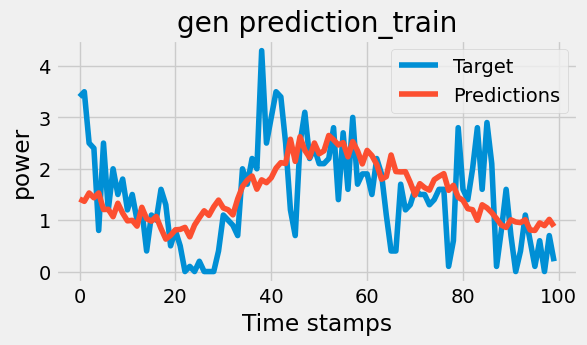

In [159]:
plt.figure(figsize=(6, 3))
plt.plot(denorm(Y_test)[:,4])
plt.plot(denorm(outtest)[:,4])
plt.title('gen prediction_train')
plt.xlabel("Time stamps")
plt.ylabel("power") 
plt.legend(['Target', 'Predictions'])
plt.show()

In [138]:
denorm(outtest)[:,2]

array([24.56667627, 24.60243776, 25.22589248, 24.28568107, 26.04584656,
       25.0480234 , 25.39284244, 24.33494607, 25.32831104, 24.12877779,
       24.04986744, 23.16293551, 23.92542774, 24.07705434, 23.7319115 ,
       22.91078216, 23.78798222, 23.37258459, 22.96901752, 23.46140371,
       23.34871361, 23.63005959, 23.11549336, 22.63375047, 22.95635649,
       23.91926362, 23.41494794, 24.30614319, 23.40168728, 23.83511557,
       23.86386448, 22.83208768, 23.92069072, 24.52918186, 24.99130509,
       25.54148891, 25.97271358, 27.75784437, 27.30695807, 27.5173267 ,
       28.06006321, 27.63798278, 30.03519944, 28.17925921, 31.48285058,
       32.38446727, 31.52196097, 31.95313467, 31.70767911, 32.65056185,
       32.5687913 , 32.65694783, 32.05090315, 33.81141943, 32.23842916,
       32.87404123, 32.09853418, 33.75051575, 34.75593314, 32.24892256,
       31.5220629 , 30.57572334, 31.24303747, 31.98339763, 30.74980581,
       31.77966982, 31.52940828, 30.62440671, 32.36886509, 31.38

In [139]:
denorm(Y_test)[:,1]

array([25.      , 24.700001, 24.700001, 24.      , 24.      , 23.1     ,
       23.5     , 23.5     , 23.5     , 23.6     , 23.5     , 23.5     ,
       23.6     , 23.799999, 23.6     , 23.6     , 23.200001, 23.200001,
       23.299999, 21.799999, 21.9     , 21.799999, 22.      , 21.9     ,
       21.6     , 21.      , 20.6     , 21.1     , 22.1     , 23.4     ,
       24.299999, 24.700001, 24.799999, 24.9     , 25.1     , 26.1     ,
       26.799999, 27.4     , 28.299999, 29.200001, 28.6     , 29.      ,
       29.299999, 29.299999, 29.6     , 29.799999, 30.5     , 31.      ,
       30.9     , 30.6     , 30.299999, 30.5     , 30.299999, 30.4     ,
       30.4     , 29.9     , 29.4     , 29.4     , 29.4     , 29.5     ,
       29.799999, 29.799999, 29.799999, 30.200001, 30.200001, 30.299999,
       30.299999, 30.4     , 30.5     , 30.299999, 30.299999, 30.200001,
       29.799999, 29.6     , 28.799999, 28.4     , 28.299999, 28.200001,
       28.200001, 28.5     , 28.5     , 28.299999, 